# Libraries import

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
import torch
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_validate

import random

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (7, 5)

# Data reading

In [2]:
data_path = 'z_ML datasets__/'

FreeSolve_df = pd.read_csv(data_path + 'SAMPL.csv')

FreeSolve_df.head(1)

,iupac,smiles,expt,calc
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625


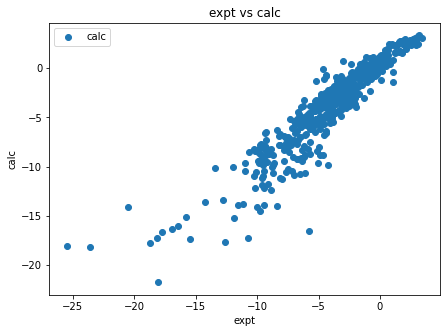

In [3]:
# plot below is taken from dataset creator article; it reflects general form of dependence between predicted value and calculated

FreeSolve_df.plot(x='expt', y='calc', style='o')  

plt.title('expt vs calc')  

plt.xlabel('expt');  plt.ylabel('calc');

plt.show()

# Data processing

,iupac,smiles,expt,calc,ROMol,n_Atoms,Molec_weight,LogP,AP,HA,MaxCharge_abs,MaxCharge
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625,,13,179.219,1.397,1,0.076923,0.496768,0.252836

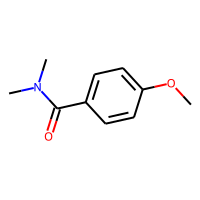

In [4]:
# before saving the file you should drop ROMol column "FreeSolve_df = FreeSolve_df.drop(['%name'], axis=1)"

seed = 1

PandasTools.AddMoleculeColumnToFrame(FreeSolve_df, smilesCol='smiles')

FreeSolve_df['n_Atoms'] = FreeSolve_df['ROMol'].map(lambda x: x.GetNumAtoms())
 
FreeSolve_df['Molec_weight'] = [Descriptors.MolWt(mol) for mol in FreeSolve_df['ROMol']]

FreeSolve_df['LogP'] = [Chem.Crippen.MolLogP(mol) for mol in FreeSolve_df['ROMol']]

FreeSolve_df['AP'] = [Chem.rdMolDescriptors.CalcNumAromaticRings(mol) for mol in FreeSolve_df['ROMol']]

FreeSolve_df['HA'] = [Chem.rdMolDescriptors.CalcNumAromaticRings(mol) / mol.GetNumHeavyAtoms() for mol in FreeSolve_df['ROMol']]

FreeSolve_df['MaxCharge_abs'] = [Descriptors.MaxAbsPartialCharge(mol) for mol in FreeSolve_df['ROMol']]

FreeSolve_df['MaxCharge'] = [Descriptors.MaxPartialCharge(mol) for mol in FreeSolve_df['ROMol']]

#FreeSolve_df = FreeSolve_df.drop(['FP_1'], axis=1)

FreeSolve_df.head(2)

,iupac,smiles,expt,calc,ROMol,n_Atoms,Molec_weight,LogP,AP,HA,MaxCharge_abs,MaxCharge
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625,,13,179.219,1.3970,1,0.076923,0.496768,0.252836
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219,,5,114.553,0.1848,0,0.000000,0.229212,0.229212
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452,,5,70.135,1.8284,0,0.000000,0.102824,-0.029310
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809,,8,108.144,1.0390,1,0.125000,0.261224,0.058343

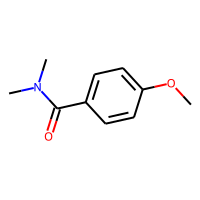
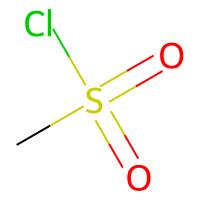
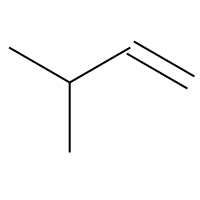
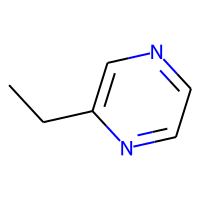

In [7]:
FreeSolve_df.head(4)

In [5]:
train_df = FreeSolve_df.sample(frac=.8, random_state = seed)
test_df = FreeSolve_df[~FreeSolve_df.index.isin(train_df.index)]

print('Train set shape:', train_df.shape, '\n', 'Test set shape:', test_df.shape)

Train set shape: (514, 12) 
 Test set shape: (128, 12)


In [6]:
target = 'calc'

dim = 7

signs = ['n_Atoms','MaxCharge_abs', 'MaxCharge', 'LogP', 'Molec_weight', 'HA', 'AP']

# train samples processing
train_y = np.asanyarray(train_df[[target]]).astype(np.float32)
train_x = np.asanyarray(train_df[[signs[0],signs[1],signs[2],signs[3],signs[4],signs[5],signs[6]]]).astype(np.float32)

train_x = torch.from_numpy(train_x.reshape(train_x.shape[0], dim))
train_y = torch.from_numpy(train_y.reshape(train_y.shape[0], 1))

# tesr samples processing
test_y = np.asanyarray(test_df[[target]]).astype(np.float32)
test_x = np.asanyarray(test_df[[signs[0],signs[1],signs[2],signs[3],signs[4],signs[5],signs[6]]]).astype(np.float32)

test_x = torch.from_numpy(test_x.reshape(test_x.shape[0], dim))
test_y = torch.from_numpy(test_y.reshape(test_y.shape[0], 1))

# Tourch NN model

torch.manual_seed(seed)

import random
random.seed(seed)## NN frame

In [122]:
class Neural_net(torch.nn.Module):                
    def __init__(self, n1, n2):                       
        super(Neural_net, self).__init__()                
        self.fc1 = torch.nn.Linear(dim, n1)          
        self.act1 = torch.nn.Tanh() 
        self.fc2 = torch.nn.Linear(n1, n2)
        self.act2 = torch.nn.Tanh() 
        self.fc3 = torch.nn.Linear(n2, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

In [123]:
n1 = 5   
n2 = 9

network = Neural_net(n1, n2)

def Predict(net, x, y):
    
    y_pred = net.forward(x)
      
    plt.plot(y.numpy(), y_pred.data.numpy(), 'o', c = 'r')
    
    plt.ylabel('Network prediction')  
    
    plt.xlabel('Calculated solubility')
    
    return y_pred
    
    #plt.legend(loc = 'upper right')
    
def RMSELoss(pred, true):
    
    return torch.sqrt(torch.mean((pred - true)**2))

## Tuner

In [124]:
torch.manual_seed(seed)

import random
random.seed(seed)

epoch = 20000

optimizer = torch.optim.Adamax(network.parameters(), lr=0.0007) 

loss_points = []

for e in range(epoch):
    
    optimizer.zero_grad() 

    y_pred = network.forward(train_x)
    
    loss_val = RMSELoss(y_pred, train_y)

    loss_val.backward()
    
    optimizer.step()
    
    loss_points.append(loss_val)
    
    if not e % (epoch//10):
        
        print(loss_val)
        
    loss_points[len(loss_points)-1]

tensor(5.6706, grad_fn=<SqrtBackward>)
tensor(1.7800, grad_fn=<SqrtBackward>)
tensor(1.4668, grad_fn=<SqrtBackward>)
tensor(1.4101, grad_fn=<SqrtBackward>)
tensor(1.3803, grad_fn=<SqrtBackward>)
tensor(1.3488, grad_fn=<SqrtBackward>)
tensor(1.3183, grad_fn=<SqrtBackward>)
tensor(1.2842, grad_fn=<SqrtBackward>)
tensor(1.1940, grad_fn=<SqrtBackward>)
tensor(1.0924, grad_fn=<SqrtBackward>)


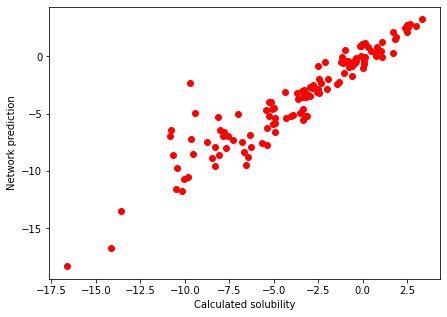

In [126]:
a = Predict(network, test_x, test_y)

In [127]:
RMSE = sklearn.metrics.mean_squared_error(test_y.detach().numpy(), a.detach().numpy(), squared=False)  

RMSE = round(RMSE, 4)

print("Accuracy: %a"%(RMSE)) 

Accuracy: 1.3835


In [247]:
for i in range(len(loss_points)):
        loss_points[i] = loss_points[i].detach().numpy()

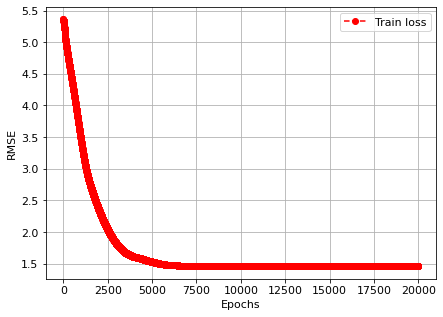

In [248]:
plt.figure(figsize=(7, 5))
plt.rcParams.update({'font.size': 11})
plt.plot(range(0, epoch), loss_points, 'ro--', label='Train loss');
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.grid()
plt.legend();

# LNet1

In [96]:
class Neural_net(torch.nn.Module):                
    def __init__(self, n):                       
        super(Neural_net, self).__init__()                
        self.fc1 = torch.nn.Linear(dim, n)          
        self.act1 = torch.nn.Tanh()             
        self.fc2 = torch.nn.Linear(n, 1)
        self.act2 = torch.nn.Tanh() 
        self.fc3 = torch.nn.Linear(n2, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        #x = self.act2(x)
        #x = self.fc3(x)
        return x

In [97]:
def search(n, train_x, train_y):
    
    network = Neural_net(n)

    def Predict(net, x, y):
        y_pred = net.forward(x)
        return y_pred
    
    def RMSELoss(pred, true):   
        return torch.sqrt(torch.mean((pred - true)**2))

    epoch = 20000
    optimizer = torch.optim.Adamax(network.parameters(), lr=0.0007) 
    loss_points = []
    
    torch.manual_seed(seed)
    random.seed(seed)
    
    for e in range(epoch):
        optimizer.zero_grad() 
        y_pred = network.forward(train_x)
        loss_val = RMSELoss(y_pred, train_y)
        loss_val.backward()
        optimizer.step()
        loss_points.append(loss_val)
    
    a = Predict(network, test_x, test_y)
    
    return a

In [121]:
res = []

for i in range(1,20):
    
    a = search(i, train_x, train_y)
    
    RMSE_loss = sklearn.metrics.mean_squared_error(test_y.detach().numpy(), a.detach().numpy(), squared=False)  

    RMSE_loss = round(RMSE_loss, 4)
    
    res_dict = {'n_neurons': i, 'RMSE': RMSE_loss}
    
    res.append(res_dict)
    
res = pd.DataFrame(res)

KeyboardInterrupt: 

In [116]:
res.sort_values(by='RMSE').head()

AttributeError: 'list' object has no attribute 'sort_values'

# LNet2

In [111]:
class Neural_net(torch.nn.Module):                
    def __init__(self, n1, n2):                       
        super(Neural_net, self).__init__()                
        self.fc1 = torch.nn.Linear(dim, n1)          
        self.act1 = torch.nn.Tanh()             
        self.fc2 = torch.nn.Linear(n1, n2)
        self.act2 = torch.nn.Tanh() 
        self.fc3 = torch.nn.Linear(n2, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

In [112]:
def search(n1, n2, train_x, train_y):
    
    network = Neural_net(n1, n2)

    def Predict(net, x, y):
        y_pred = net.forward(x)
        return y_pred
    
    def RMSELoss(pred, true):   
        return torch.sqrt(torch.mean((pred - true)**2))

    epoch = 20000
    optimizer = torch.optim.Adamax(network.parameters(), lr = 0.0007) 
    loss_points = []
    
    torch.manual_seed(seed)
    random.seed(seed)
    
    for e in range(epoch):
        optimizer.zero_grad() 
        y_pred = network.forward(train_x)
        loss_val = RMSELoss(y_pred, train_y)
        loss_val.backward()
        optimizer.step()
        loss_points.append(loss_val)
        
        if e==epoch-1:
            print(loss_val)
    
    a = Predict(network, test_x, test_y)
    
    return a

In [113]:
res_2 = []

for i in range(1,21, 2):
    
    for j in range(1,11, 2):
    
        a = search(i, j, train_x, train_y)
    
        RMSE_loss = sklearn.metrics.mean_squared_error(test_y.detach().numpy(), a.detach().numpy(), squared=False)  

        RMSE_loss = round(RMSE_loss, 4)
    
        res_dict = {'n_neurons_1': i, 'n_neurons_2': j, 'RMSE': RMSE_loss}
    
        res_2.append(res_dict)
    
res_2 = pd.DataFrame(res_2)

tensor(1.8300, grad_fn=<SqrtBackward>)
tensor(1.8136, grad_fn=<SqrtBackward>)
tensor(1.8127, grad_fn=<SqrtBackward>)
tensor(1.7932, grad_fn=<SqrtBackward>)
tensor(1.8060, grad_fn=<SqrtBackward>)
tensor(1.5335, grad_fn=<SqrtBackward>)
tensor(1.3725, grad_fn=<SqrtBackward>)
tensor(1.3888, grad_fn=<SqrtBackward>)
tensor(1.4241, grad_fn=<SqrtBackward>)
tensor(1.4335, grad_fn=<SqrtBackward>)
tensor(1.4298, grad_fn=<SqrtBackward>)
tensor(1.2916, grad_fn=<SqrtBackward>)
tensor(1.2649, grad_fn=<SqrtBackward>)
tensor(1.3101, grad_fn=<SqrtBackward>)
tensor(1.0506, grad_fn=<SqrtBackward>)
tensor(1.3027, grad_fn=<SqrtBackward>)
tensor(1.1641, grad_fn=<SqrtBackward>)
tensor(1.1867, grad_fn=<SqrtBackward>)
tensor(1.0509, grad_fn=<SqrtBackward>)
tensor(1.0831, grad_fn=<SqrtBackward>)
tensor(1.2503, grad_fn=<SqrtBackward>)
tensor(1.1868, grad_fn=<SqrtBackward>)
tensor(1.0689, grad_fn=<SqrtBackward>)
tensor(0.9456, grad_fn=<SqrtBackward>)
tensor(0.7950, grad_fn=<SqrtBackward>)
tensor(1.2263, grad_fn=<S

In [114]:
res_2.sort_values(by='RMSE').head()

,n_neurons_1,n_neurons_2,RMSE
14,5,9,1.3835
42,17,5,1.5015
32,13,5,1.5110
19,7,9,1.5144
39,15,9,1.5260


In [118]:
path = 'C:/Users/7000f/OneDrive/Рабочий стол/пту/7 семестр/УИРС/torch_tuning/'

res_2.to_csv(path + 'Two-layer NN RMSE', index=False)